In [189]:
from garminconnect import Garmin
import datetime
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import garth

In [89]:
email = os.getenv("GARMIN_EMAIL")
password = os.getenv("GARMIN_PASSWORD")
email = "miles96@live.com"
password = "@Track98"

garth.http.USER_AGENT = {"User-Agent": ("GCM-iOS-5.7.2.1")} # Patch bug in garminconnect code

garmin_api = Garmin(email=email, password=password)
garmin_api.login()

True

In [150]:
activities = garmin_api.get_activities(0, 10000)

df = pd.DataFrame(columns=['Date', 'Start Time', 'Distance', 'Duration', 'Pace', 'Elevation Gain', 'Heart Rate', 'VO2 Max', 'Cadence', 'Activity Load'])

for i in range(len(activities)):
    # print(activities[i])
    activityType = activities[i]['activityType']['typeKey']
    if activityType == 'running':
        try:
            distance = activities[i]['distance']/1609 # [units: miles]
        except:
            pass
            
        try:
            vO2Max = activities[i]['vO2MaxValue'] # [units: mL/kg-min]
        except:
            vO2Max = None

        try:
            duration = activities[i]['movingDuration']/60 # [units: minutes]
        except:
            duration = activities[i]['duration']/60 # [units: minutes]

        try:
            avgHR = activities[i]['averageHR'] # [units: bpm]
        except:
            avgHR = None

        startTime = activities[i]['startTimeLocal'] # [units: bpm]

        try:
            cadence = activities[i]['averageRunningCadenceInStepsPerMinute'] # [units: bpm]
        except:
            cadence = None

        try:
            elevationGain = activities[i]['elevationGain'] # [units: bpm]
        except:
            elevationGain = None

        # splitSummaries = activities[i]['splitSummaries']
        try:
            activityLoad = activities[i]['activityTrainingLoad']
        except:
            activityLoad = None

        avgPace = duration/distance
        date = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S").date()
        time = datetime.datetime.strptime(startTime, "%Y-%m-%d %H:%M:%S").time()

        new_row = {
            'Date': date,
            'Start Time': time,
            'Distance': distance,
            'Duration': duration,
            'Pace': avgPace,
            'Elevation Gain': elevationGain,
            'Heart Rate': avgHR,
            'VO2 Max': vO2Max,
            'Cadence': cadence,
            'Activity Load': activityLoad
        }
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        
display(df)

/var/folders/hx/mzdy_0px4vjdf00n9svk8mfw0000gn/T/ipykernel_71733/3610297119.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,Date,Start Time,Distance,Duration,Pace,Elevation Gain,Heart Rate,VO2 Max,Cadence,Activity Load
0,2024-12-01,09:16:15,14.013474,91.283333,6.513969,149.00,152.0,68.0,178.796875,230.599945
1,2024-11-30,09:04:20,10.230833,72.750000,7.110858,37.00,145.0,68.0,178.359375,128.978607
2,2024-11-29,10:19:46,10.449546,68.835950,6.587458,65.00,148.0,68.0,174.156250,189.912170
3,2024-11-28,13:00:29,10.292995,70.040633,6.804689,78.00,150.0,68.0,177.906250,165.487839
4,2024-11-27,15:42:28,11.205425,79.533333,7.097752,119.00,142.0,68.0,177.750000,131.704987
...,...,...,...,...,...,...,...,...,...,...
3314,2015-07-10,09:09:34,5.003971,33.740100,6.742664,45.57,NaN,NaN,NaN,NaN
3315,2015-07-09,18:40:37,2.243965,14.397367,6.416038,NaN,NaN,NaN,NaN,NaN
3316,2015-07-07,18:12:12,2.882393,16.880033,5.856257,11.84,NaN,NaN,NaN,NaN
3317,2015-07-06,18:39:35,0.383841,1.674700,4.363006,NaN,NaN,NaN,NaN,NaN


In [151]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
dates = df['Date'].to_numpy()
distance = df['Distance'].to_numpy()
VO2_Max = df['VO2 Max'].to_numpy()
dates = [pd.to_datetime(d) for d in dates]
df = df.set_index('Date')
weekly_distance = df['Distance'].resample('W-SAT').sum()
weekly_start = weekly_distance.index - pd.Timedelta(days=6)

In [208]:
vo2df = pd.read_excel('VDOTtoIAAF.xlsx')
vdot = vo2df['VDOT']
iaaf = vo2df['IAAF Points (2017 Mens)']

vdot2iaaf = interp1d(vdot,iaaf, kind='quadratic')

iaaf_garmin = vdot2iaaf(VO2_Max)

In [219]:
racesdf = pd.read_excel('RACEtoIAAF.xlsx')
race_dates = racesdf['Date'].to_numpy()
race_dates = [pd.to_datetime(d) for d in race_dates]
race_score = racesdf['IAAF Points']


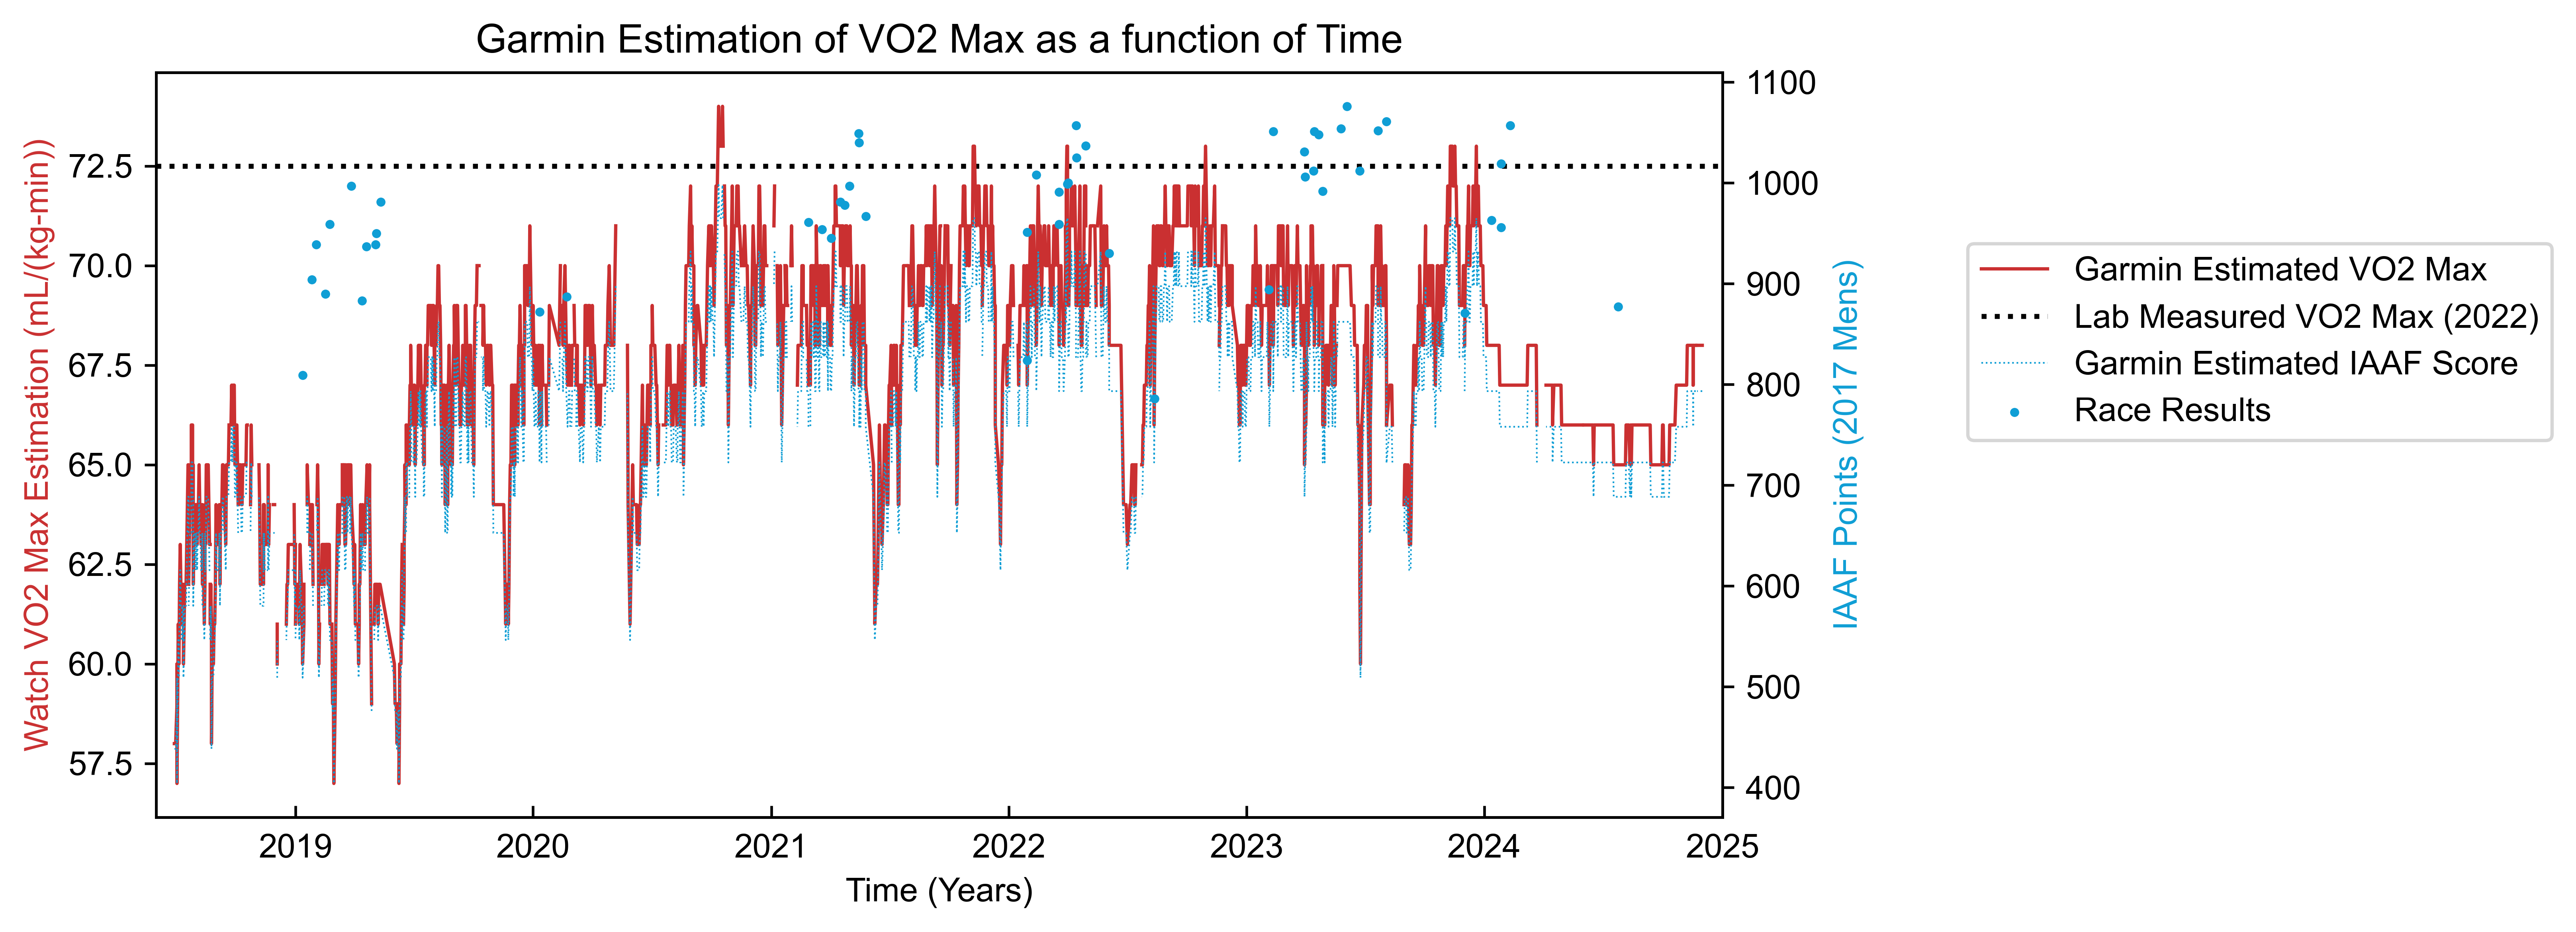

In [230]:
plt.rcParams['font.family'] = 'Arial'  # Set the font to Arial
plt.rcParams['font.size'] = 10  # Set the font size to 12

start_date = pd.to_datetime('2018-6-1', format='%Y-%m-%d')
end_date = pd.to_datetime('2025-1-1', format='%Y-%m-%d')

vo2_fig, vo2_ax = plt.subplots(figsize=(8, 4), dpi=600)
vo2_ax2 = vo2_ax.twinx()
# vo2_ax.grid()
vo2_ax.plot(dates, VO2_Max, color='#CA3031',zorder=3, linewidth=1, label='Garmin Estimated VO2 Max')
vo2_ax2.plot(dates, iaaf_garmin, color='#0F9ED5',zorder=3, linewidth=0.5, linestyle='dotted', label='Garmin Estimated IAAF Score')
vo2_ax2.scatter(race_dates, race_score, color='#0F9ED5',zorder=3, s=3, label='Race Results')
vo2_ax.hlines(y=[72.5], xmin=start_date, xmax=end_date, colors='#CA3031', linestyles='dotted', label='Lab Measured VO2 Max (2022)')
vo2_ax2.hlines(y=[947], xmin=start_date, xmax=end_date, colors='#0F9ED5', linestyles='dotted', label='Lab Measured VO2 Max (2022)')
vo2_ax.set_ylabel('Watch VO2 Max Estimation (mL/(kg-min))', color='#CA3031')
vo2_ax2.set_ylabel('IAAF Points (2017 Mens)', color='#0F9ED5')
vo2_ax.set_xlabel('Time (Years)')
vo2_ax.set_title('Garmin Estimation of VO2 Max as a function of Time')
vo2_ax.tick_params(axis="x",direction="in", pad=5)
vo2_ax.set_xlim([start_date, end_date])
vo2_ax.set_xlim([start_date, end_date])
vo2_fig.legend(bbox_to_anchor=(1.35, 0.75))
vo2_fig.tight_layout()